In [46]:
####################################################################################################
# CR.Tau_QsiBias.ipynb
# Karl Lapo September/2015
####################################################################################################
# Plots bias in Qsi and Tau between ground observations and products
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [2]:
####################################################################################################
# Functions
####################################################################################################

In [5]:
#### Function taking mean across grouping variable, leaving other dimensions untouched
def group_mean(ds_in,grouping_var,groups):
    gr_ds = xray.Dataset()
    for gr in groups:
        gr_ds[gr] = ds_in.loc[{grouping_var:gr}].mean(grouping_var)
    return(gr_ds)
    
#### Function for combining xray data variables into a single array with new labeled dimension
def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
    ds_out = xray.Dataset()
    ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
    ds_out = ds_out.rename({'new_dim': new_dim_name})
    ds_out.coords[new_dim_name] = dat_vars
    ds_out = xray.Dataset({combinevarname:ds_out})

    return ds_out

In [6]:
##### Load daily data

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.daily.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})
nldas.SWdwn.values[nldas.SWdwn.values > 2000] = np.nan

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.daily.nc')
############ No flipping -- SYN reformatted on 08/20/15 for CR.Composite. OTHER SCRIPTS WILL NEED THIS FIX

#########
## VIC ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.daily.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.daily.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

In [7]:
##### Process daily ground observations
os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
grobs = grobs.resample(freq='D', dim='time', how='mean')
grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
grobs.longitude.values = -grobs.longitude.values

## Remove stations outside study domain
# Bounding box - ragged domain
LL_rag = [-120,34.5]
LR_rag = [-115,34.5]
UR_rag = [-118.5,41]
UL_rag = [-123.5,41]

# Station lat/lon
stat_lat = grobs.latitude.values
stat_lon = grobs.longitude.values

# Ragged domain, CA study area
line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
# Reindex
stat_to_keep = grobs.station[ind]
grobs = grobs.reindex(station=stat_to_keep)

## Append station group information
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})    
# Merge into ground observation structure
grobs = grobs.merge(stdat,join='inner')
grobs = grobs.rename({'SWdwn':'grobs'})


In [8]:
#### Combine
## List w/ all irradiance datasets
daily_mean = {}
daily_mean['syn'] = syn
daily_mean['nldas'] = nldas
daily_mean['mtclim'] = mtclim
daily_mean['wrf'] = wrf
daily_mean['grobs'] = grobs

## Names
# Product names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

In [9]:
####################################################
## Find grid point containing each ground station ##
####################################################
# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

for pr in pr_names:        
    if pr == 'grobs':
        continue
    # lat/lon for product
    lon_rad = daily_mean[pr].longitude.values
    lat_rad = daily_mean[pr].latitude.values  
    # mesh
    lonm, latm = np.meshgrid(lon_rad,lat_rad)
    
    # Empty numpy array
    to_merge = np.empty((daily_mean[pr].time.size,grobs.station.size))
    
    ## Product values in each grid containing station
    for stat in grobs.station.values:
        
        # Station index
        stat_ind = np.where(stat == grobs.station.values)
        # Distance to product grid lat-lon
        d = (latm-lat_stat[stat_ind])**2 + (lonm-lon_stat[stat_ind])**2
        # Index of closest product grid
        dind = np.where(d==np.amin(d))
        # Grad grid values at the station, put into xray dataset
        if (daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]] == 0).all() \
                | np.isnan(daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]]).all():
            to_merge[:,stat_ind[0]] = daily_mean[pr].SWdwn.values[:,dind[0][0]+1,dind[1][0],np.newaxis]
        else:
            to_merge[:,stat_ind[0]] = daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0],np.newaxis]
    
    ## Merge products w/ grobs xray structure
    to_merge_ds = xray.Dataset({pr:(('time','station'),to_merge), \
                                    'time':daily_mean[pr].time.values,\
                                    'station':grobs.station.values})
    grobs = grobs.merge(to_merge_ds)

In [10]:
#### Elevation Angle
import solargeo
d = pd.to_datetime(grobs.time.values)
el = xray.Dataset()
for stat in grobs.station.values:
    el[stat] = (('time'),solargeo.AVG_EL(d,\
                     grobs.loc[{'station':stat}].latitude.values,\
                     grobs.loc[{'station':stat}].longitude.values,\
                     0,'END'))
el = combinevars(el,el.data_vars,new_dim_name='station',combinevarname='el')
el.coords['time'] = d

# Add to xray Dataset
grobs.update(el)

<xray.Dataset>
Dimensions:    (station: 73, time: 5753)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
  * station    (station) |S19 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    Grouping   (station) object 'south cv' 'foothills' 'foothills' ...
Data variables:
    grobs      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    mtclim     (time, station) float64 113.1 69.73 94.44 114.6 113.9 110.2 ...
    nldas      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    syn        (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    wrf        (time, station) float64 nan nan nan nan nan nan na

In [96]:
#### Data structure formatting

## Transmissivity
tau = xray.Dataset()
pr_names_proc = pr_names.append('grobs')
for pr in pr_names:
    tau[pr] = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)

## Group Mean Transmissivity
tau = tau.swap_dims({'station':'Grouping'})
tau_mean = xray.Dataset()
for pr in pr_names:
    ds_mean = group_mean(tau[pr],'Grouping',grouping)
    ds_mean = combinevars(ds_mean,grouping,new_dim_name='Grouping',combinevarname=pr)
    tau_mean[pr] = ds_mean[pr]

## Biases - Qsi and tau
grobs_diff = xray.Dataset()
tau_diff = xray.Dataset()
for pr in pr_names:
    ## Format Qsi bias
    grobs_diff[pr] = (grobs[pr]-grobs.grobs)
    ## Format tau bias
    tau_diff[pr] = (tau_mean[pr]-tau_mean.grobs)

# Resample to monthly
grobs_diff = grobs_diff.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
tau_diff = tau_diff.resample(freq='M', dim='time', how='mean')

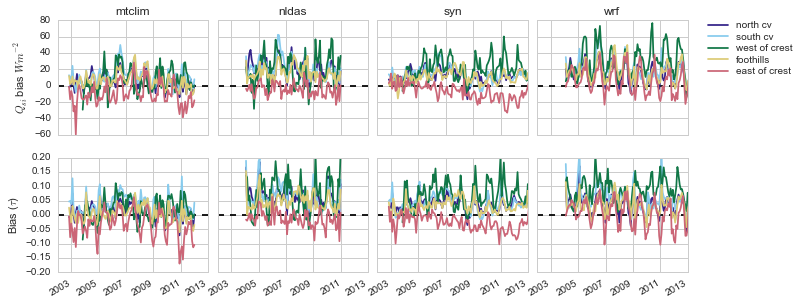

In [94]:
#####################################
## Time series of bias by Grouping ##
#####################################
# formating preface
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
colsche = kgraph.SRON(5)
fig = plt.figure(figsize=(12,5))
gs = matplotlib.gridspec.GridSpec(2,5,\
                                  width_ratios=np.array((5,5,5,5,1)))
gs.update(wspace=0.075)

for n,pr in enumerate(pr_names):
    ###################
    # Shortwave Bias ##
    ###################
    if pr == 'grobs':
        continue
    ax = plt.subplot(gs[0,n])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    
    ## Format Qsi bias
    grobs_diff = (grobs[pr]-grobs.grobs)
    grobs_diff = grobs_diff.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
    
    for m,gr in enumerate(grouping):
        plt.plot(grobs_diff.time,grobs_diff.loc[{'Grouping':gr}].mean(dim='Grouping'),color=colsche[m],label=gr)
    
    # Labels
    if n == 0:
        ax.set_ylabel('$Q_{si}$ bias $Wm^{-2}$')
        # Legend handles
        handles, labels = ax.get_legend_handles_labels()
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-60,80)
    ax.set_title(pr)
    
    ###################
    #    Tau Bias    ##
    ###################
    ax = plt.subplot(gs[1,n])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')

    ## Format tau bias
    tau_diff = (tau_mean[pr]-tau_mean.grobs)
    tau_diff = tau_diff.resample(freq='M', dim='time', how='mean')

    # Plot tau bias
    for m,gr in enumerate(grouping):
        plt.plot(tau_diff.time,tau_diff.loc[{'Grouping':gr}],color=colsche[m],label=gr)
    
    # Labels
    if n == 0:
        ax.set_ylabel('Bias ($\\tau$)')
        # Legend handles
        handles, labels = ax.get_legend_handles_labels()
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-.2,.2)

    
# Legend
ax = plt.subplot(gs[0,-1])
ax.legend()   
ax.axis('off')
ax.legend(handles, labels,loc='center',ncol=1,\
                    labelspacing=.25,markerscale=1,numpoints=1,\
                    bbox_to_anchor=(1.5, .5, .5, .5))
fig.autofmt_xdate()

os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.groups.png'
fig.savefig(fname)


In [98]:
#########################################################
## Time series of bias by Grouping - Each individually ##
#########################################################
# formating preface
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
colsche = kgraph.SRON(5)

for n,gr in enumerate(grouping):
    fig, axes = plt.subplots(2,4,figsize=(12,6),sharex='col',sharey='row')
    for m,pr in enumerate(pr_names):
        if pr == 'grobs':
            continue
        ax = axes[0,m]
        
        ###################
        # Shortwave Bias ##
        ###################
        ax.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
        ax.plot(grobs_diff.time,grobs_diff[pr].loc[{'Grouping':gr}],\
                color='b',label=gr,alpha=.6,lw=.5)
        ax.plot(grobs_diff.time,grobs_diff[pr].loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='r',label=gr,lw=3)


        # Labels
        if m == 0:
            ax.set_ylabel('$Q_{si}$ bias $Wm^{-2}$')
        ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
        ax.set_ylim(-60,80)
        ax.set_title(pr)
    
        ###################
        #    Tau Bias    ##
        ###################
        ax = axes[1,m]
        ax.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
        
        ax.plot(tau.resample(freq='M',how='mean',dim='time').time,\
                (tau[pr].loc[{'Grouping':gr}]-tau.grobs.loc[{'Grouping':gr}]).resample(\
                freq='M',how='mean',dim='time'),\
                color='b',label=gr,alpha=.6,lw=.5)
        
        ax.plot(tau_diff.time,tau_diff[pr].loc[{'Grouping':gr}],\
                color='r',label=gr,lw=3)
    
        # Labels
        if m == 0:
            ax.set_ylabel('Bias ($\\tau$)')
        ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
        ax.set_ylim(-.2,.2)
    
    plt.tight_layout()
    os.chdir(dir_print)
    fname = 'SWdwn_Tau.MonthlyBias.'+gr+'.png'
    fig.savefig(fname)
    plt.close(fig)


In [112]:
#########################################################
##      Time series of bias by Grouping - Panel        ##
#########################################################
# formating preface
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
grouping_shortlabel = ['NCV','SCV','FHLLS','WC','EC']
colsche = kgraph.SRON(5)

fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(5,4)
gs.update(wspace=0.075)

for n,gr in enumerate(grouping):
    for m,pr in enumerate(pr_names):
        if pr == 'grobs':
            continue
        ax = plt.subplot(gs[n,m])
        
        ###################
        # Shortwave Bias ##
        ###################
        ax.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
        ax.plot(grobs_diff.time,grobs_diff[pr].loc[{'Grouping':gr}],\
                color=colsche[n],label=gr,alpha=.6,lw=.5)
        ax.plot(grobs_diff.time,grobs_diff[pr].loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color=colsche[n],label=gr,lw=3)
        
        # Labels - products
        if n == 0:
            ax.set_title(pr)
        # Labels - groups
        if m == 0:
            ax.set_ylabel(grouping_shortlabel[n]+' bias Wm$^{-2}$')

        else:
            ax.yaxis.set_ticklabels([])
        ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
        ax.set_ylim(-60,80)
    
fig.autofmt_xdate()
   
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.AllGroups.png'
fig.savefig(fname)
plt.close(fig)
